# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
llamadas=pd.read_csv(r"megaline_calls.csv")

internet=pd.read_csv(r"megaline_internet.csv")

mensajes=pd.read_csv(r"megaline_messages.csv")

planes=pd.read_csv(r"megaline_plans.csv")

usuarios=pd.read_csv(r"megaline_users.csv")


## Preparar los datos

Para poder dar un primer vistazo a como están constituidas cada data frame se usará info() y head(), el primero para determinar en primera instancia el tipo de datos que maneja cada columna así como si hay valores faltantes, por otro lado head() nos dara una visión sobre como se plasma la información dentro del data frame.

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
planes.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
print(planes.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Se puede observar que en este data frame la mayoría de los datos son de tipo numérico entre int64 y float64, salvo el nombre del plan que es de tipo objeto, en este caso el tipo de dato que maneja cada columna es correcto pues en donde se necesita números enteros para establecer un limite se tiene la cantidad adecuada según los parámetros mostrados al iniciar el proyecto, sin embargo al comparar la información que se dio previamente los valores en la columna mp_per_month_included son erronéos, para corregirlos bastaria con usar replace o simplemente igualar la variable que apunte a los datos para modificarlos. Hablando de los valores ausentes se observa que no hay ninguno del cual preocuparnos.

## Corregir datos

Para poder modificar los valores erróneos dentro de la columna mb_per_month_included se utilizará replace y después se imprimirá únicamente los valores que se están modificando con el fin de comprobar su corrección

In [5]:
#planes["mb_per_month_included"]=planes["mb_per_month_included"].replace([15360,30720],[15000,30000])
#print(planes["mb_per_month_included"])
print(planes.duplicated().sum())#Corroborar valores duplicados
print(planes.isna().sum())#Corroborar valores ausentes

0
messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64


## Enriquecer los datos

Se utilizará rename con el fin de modificar el nombre de la columna usd_monthly_pay a usd_monthly_fee como se presento al inicio del proyecto. 

In [6]:
planes.rename(columns={"usd_monthly_pay":"usd_monthly_fee"},inplace=True)
print(planes.columns)

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_fee', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
usuarios.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
usuarios.sample(n=5)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
252,1252,Mitsue,York,27,"Detroit-Warren-Dearborn, MI MSA",2018-06-10,surf,NaN
357,1357,Ria,Beach,61,"Baton Rouge, LA MSA",2018-05-30,surf,NaN
332,1332,Lucas,Saunders,37,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-12,surf,NaN
279,1279,Neal,Duke,27,"Baton Rouge, LA MSA",2018-02-05,ultimate,NaN
71,1071,Isa,Roy,29,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-05-23,surf,NaN


En este caso se ven datos ausentes pertenecientes a la columna churn_date auque es de esperarse debido a que es probable que se deba a que la tarifa aun se esta usando al momento de que se extrajeron los datos, lo apropiado sería cambiarlos ya sea a 0 o a algún string que haga referencia a lo afirmado anteriormente o incluso dejarlo tal cual esta pero considerando la situación en futuros análisis. En cuanto al tipo de datos que maneja cada una de las columnas no veo ningún problema salvo en las columnas reg_date y churn_date en las cuales pueden ser cambiadas a tipo datetime.

### Corregir los datos

Se modifico mediante to_datetime los valores de las fechas en las columnas churn_date y reg_date, por otra parte en churn_date se ignoran los valores vacios con errors="coerce".

In [9]:
usuarios["reg_date"]=pd.to_datetime(usuarios["reg_date"],format='%Y-%m-%d')
#usuarios["churn_date"]=pd.to_datetime(usuarios["churn_date"],format='%Y-%m-%d',errors="coerce")

print(usuarios.duplicated().sum())#Corroborar valores duplicados
print(usuarios.isna().sum())#Corroborar valores ausentes
usuarios.info()

0
user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


### Enriquecer los datos

Se cambiaron los valores ausentes en la columna churn_date con el valor Tarifa activa para hacer referencia a que aun esta en uso, de ser necesario en el futuro se modificará para que sean de tipo datetime.

In [10]:
usuarios["churn_date"]=usuarios["churn_date"].fillna("Tarifa activa")
print(usuarios.sample(5))
usuarios.info()

     user_id first_name  last_name  age                                 city  \
475     1475      Arlen     Sutton   66  Dallas-Fort Worth-Arlington, TX MSA   
415     1415    Rosette     Mendez   56   Boston-Cambridge-Newton, MA-NH MSA   
167     1167   Rebbecca  Nicholson   47       Denver-Aurora-Lakewood, CO MSA   
411     1411        Man    Fleming   64                    Rochester, NY MSA   
401     1401   Charmain     Bryant   67                     Richmond, VA MSA   

      reg_date      plan     churn_date  
475 2018-05-28  ultimate  Tarifa activa  
415 2018-02-27      surf  Tarifa activa  
167 2018-04-06      surf  Tarifa activa  
411 2018-08-10      surf  Tarifa activa  
401 2018-08-24  ultimate  Tarifa activa  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  50

## Llamadas

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
llamadas.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para las llamadas
l=llamadas.sample(n=5)
print(l)

              id  user_id   call_date  duration
117517  1411_117     1411  2018-08-26      9.15
39956   1147_771     1147  2018-10-12      5.24
134170  1488_305     1488  2018-10-19     10.63
137733  1499_202     1499  2018-10-10      0.37
9934     1045_53     1045  2018-11-23     11.66


Se puede observar en primera instancia que no parece haber valores ausentes dentro de este data frame, además que los tipos de datos que presentan en cada columna son adecuados para realizar operaciones necesarias si se lo requiere, el único que podría llegar a ser modificado es la columna call date a un tipo de dato datetime. Por otra parte aun falta corroborar que no hay valores duplicados y en caso de haberlos simplemente bastaría con eliminarlos con dropna.

### Corregir los datos

Se comprueba la existencia de valores nulos o ausentes que se pasaron por alto y se comprueba la existencia de datos duplicados, por otra parte se modifica el nombre de id a call_id con el fin de que describa mejor que valores contiene.

In [13]:
llamadas.rename(columns={"id":"call_id"},inplace=True)
print(llamadas.duplicated().sum())#Corroborar valores duplicados
print(llamadas.isna().sum())#Corroborar valores ausentes
print(llamadas["duration"].head(10))#Comprobando valores sin redondear
llamadas["duration"]=np.ceil(llamadas["duration"])#función ceil para redondear
print(llamadas["duration"].head(10))#comprobando los mismos valores para asegurar el cambio

0
call_id      0
user_id      0
call_date    0
duration     0
dtype: int64
0     8.52
1    13.66
2    14.48
3     5.76
4     4.22
5     2.20
6     5.75
7    14.18
8     5.77
9     4.40
Name: duration, dtype: float64
0     9.0
1    14.0
2    15.0
3     6.0
4     5.0
5     3.0
6     6.0
7    15.0
8     6.0
9     5.0
Name: duration, dtype: float64


### Enriquecer los datos

Para la columna call_date se modificara el tipo de dato que maneja de tipo objeto a datetime.

In [14]:
llamadas["call_date"]=pd.to_datetime(llamadas["call_date"],format='%Y-%m-%d')
llamadas.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   call_id    137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
mensajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
print(mensajes.sample(5))

             id  user_id message_date
21519  1132_899     1132   2018-09-15
20973  1132_126     1132   2018-05-31
38810  1254_467     1254   2018-12-14
6757    1057_81     1057   2018-12-23
22970  1137_505     1137   2018-11-01


Se puede onservar que este data frame no presenta valores ausentes y el tipo de datos que maneja cada columna es correcto, puede llegar a modificarse el nombre de la columna id a call_id para que haga referencia a que es el número identificador de la llamada, la columna message_date puede ser cambiada de tipo object a datetime y finalmente comprobar la existencia de duplicados. 

### Corregir los datos

Se comprueba la existencia de valores ausentes, duplicados y se cambia el nombre de la columna id a message_id con el fin de que sea más descriptivo los valores que contiene.

In [17]:
mensajes.rename(columns={"id":"message_id"},inplace=True)
print(mensajes.isna().sum())
print(mensajes.duplicated().sum())

message_id      0
user_id         0
message_date    0
dtype: int64
0


### Enriquecer los datos

Se cambia el tipo de dato de la columna call_date a datetime para que se tenga un formato establecido.

In [18]:
#1.9.2
mensajes["message_date"]=pd.to_datetime(mensajes["message_date"],format='%Y-%m-%d')
mensajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   message_id    76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Internet

In [19]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Imprime una muestra de datos para el tráfico de internet
print(internet.sample(5))

             id  user_id session_date  mb_used
17457   1079_62     1079   2018-09-25   529.15
68626  1320_290     1320   2018-06-25   573.86
69652   1325_54     1325   2018-12-17     0.00
12253  1059_364     1059   2018-11-17   448.01
84946  1397_189     1397   2018-09-12   377.90


Se observa que los tipos de datos que se maneja en cada columna son adecuados excepto en la columna session_date la cual se modificara de object a datetime, no se encontraron valores ausentes y falta corroborar si existen duplicados.
El nombre de la columna id se modificará de id a session_id para que describa mejor los valores que contiene.

### Corregir los datos

Se modificara el nombre de la columna id a session_id, se buscará la existencia de valoes ausentes y duplicados, en caso de haberlos elimonarlos.

In [21]:
internet.rename(columns={"id":"session_id"},inplace=True)
print(internet.isna().sum())
print(internet.duplicated().sum())

session_id      0
user_id         0
session_date    0
mb_used         0
dtype: int64
0


### Enriquecer los datos

Se cambia el tipo de dato de la columna session_date a datetime 

In [22]:
internet["session_date"]=pd.to_datetime(internet["session_date"],format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## Estudiar las condiciones de las tarifas

Se imprime información general del data frame de las tarifa justo con los datos que contiene

In [23]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
planes.info()
print(planes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_fee        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_fee  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10           

## Agregar datos por usuario
Se crearan grupos tomando como referencia la columna de periodo y user_id con el fin de obtener mensualmente las cantidades correspondientes a las columnas de interés.

In [24]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
llamadas["periodo"]=llamadas["call_date"].dt.to_period("M")
df1=llamadas.groupby(["user_id","periodo"])["call_id"].size().reset_index(name="Month_call")
#print(df1)

In [25]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
df2=llamadas.groupby(["user_id","periodo"])["duration"].sum().reset_index(name="Month_duration")
#print(df2)

In [26]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
mensajes["periodo"]=mensajes["message_date"].dt.to_period("M")
df3=mensajes.groupby(["user_id","periodo"])["message_id"].size().reset_index(name="Month_message")
#print(df3)

In [27]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet["periodo"]=internet["session_date"].dt.to_period("M")
df4=internet.groupby(["user_id","periodo"])["mb_used"].sum().reset_index(name="Month_GB")
df4["Month_GB"]=np.ceil(df4["Month_GB"]/1024) #Se realiza redondeo a la columna Month_mb que se divide entre 1024 para pasar
#de mb a gb
#print(df4)


Se juntan los data frames obtenidos previamente en uno mayor.

In [28]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
lista=[df2,df3,df4]
df_all=df1
for n in lista:
    df_all=pd.merge(df_all,n,on=["user_id","periodo"],how="outer")

df_all=df_all.fillna(0)
print(df_all.isna().sum())
print(df_all.duplicated().sum())

user_id           0
periodo           0
Month_call        0
Month_duration    0
Month_message     0
Month_GB          0
dtype: int64
0


In [29]:
# Añade la información de la tarifa

usuarios.rename(columns={"plan":"plan_name"},inplace=True)
df5=usuarios.merge(planes,on="plan_name",how="outer")
#print(df5)

df_allT=pd.merge(df_all,df5,on="user_id",how="outer")

#print(df_allT.isna().sum())
#print(df_allT.duplicated().sum())
print(df_allT[df_allT.isna().any(axis=1)])

list2=["Month_call", "Month_duration", "Month_message" ,"Month_GB"]
for d in list2:
    df_allT[d].fillna(0,inplace=True)
    
print(df_allT.isna().sum())
#Se va a dejar el periodo con valores nulos, la razón por la que aparecieron valores nulos dentro de este dataframe se debe a que 
#los usuarios que no se encuentran en el dataframe df_all no tienen registro alguno o exsitencia dentro del mismo y al agregar
#el data frame con todos los usuarios registrados se generan zonas vacias, por lo que se sustituiran con cero dado que no existe 
#registro o actividad de esos usuarios en los data frame llamadas,internet y mensajes. 

      user_id periodo  Month_call  Month_duration  Month_message  Month_GB  \
86       1025     NaT         NaN             NaN            NaN       NaN   
612      1129     NaT         NaN             NaN            NaN       NaN   
682      1143     NaT         NaN             NaN            NaN       NaN   
1285     1269     NaT         NaN             NaN            NaN       NaN   
1297     1275     NaT         NaN             NaN            NaN       NaN   
1418     1307     NaT         NaN             NaN            NaN       NaN   
1466     1319     NaT         NaN             NaN            NaN       NaN   
1762     1378     NaT         NaN             NaN            NaN       NaN   
2139     1463     NaT         NaN             NaN            NaN       NaN   
2189     1473     NaT         NaN             NaN            NaN       NaN   

      first_name  last_name  age                                       city  \
86          Jess  Wilkinson   64      Atlanta-Sandy Springs-Ro

C:\Users\hadgu\AppData\Local\Temp\ipykernel_12376\418788966.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_allT[d].fillna(0,inplace=True)


Se creará una nueva columna que refleje la suma de los ingresos en general de las distintas secciones de interés, en este caso la columna sera total y se sumara con el valor del usuario al excederse del plan que tiene establecido.

In [30]:
# Calcula el ingreso mensual para cada usuario
def exceso(row1,row2):
    return max(0,row1-row2)#Devuelve el valor maximo entre dos argumentos si es negativo devuelve 0 si es positivo devueve el número 
                           #obtenido
df_allT["mb_per_month_included"]=df_allT["mb_per_month_included"]/1024#Me percate que ahora que vengo con  GB 
#Esta columna necesariamente tiene que ser GB para realizar la operación.
df_allT["Exceso_minutos"]= df_allT.apply(lambda row: exceso(row["Month_duration"],row["minutes_included"]),axis=1)
df_allT["Exceso_mensajes"]=df_allT.apply(lambda row: exceso(row["Month_message"],row["messages_included"]),axis=1)
df_allT["Exceso_GB"]=df_allT.apply(lambda row: exceso(row["Month_GB"],row["mb_per_month_included"]),axis=1)

df_allT["Exceso_minutos"]= (df_allT["Exceso_minutos"])*df_allT["usd_per_minute"]
df_allT["Exceso_mensajes"]= (df_allT["Exceso_mensajes"])*df_allT["usd_per_message"]
df_allT["Exceso_GB"]= (df_allT["Exceso_GB"])*df_allT["usd_per_gb"]

#print(df_allT.sample(5))
df_allT["total"]=df_allT["usd_monthly_fee"]+df_allT["Exceso_minutos"]+df_allT["Exceso_mensajes"]+df_allT["Exceso_GB"]
#print(df_allT.sample(5))
agrupacion_por_usuario_2=df_allT.groupby("user_id")["total"].sum().reset_index()
print(agrupacion_por_usuario_2)


     user_id   total
0       1000   70.00
1       1001  250.09
2       1002  100.00
3       1003  158.12
4       1004  610.00
..       ...     ...
495     1495  473.30
496     1496  140.00
497     1497   70.00
498     1498  850.00
499     1499  220.00

[500 rows x 2 columns]


## Estudia el comportamiento de usuario

Se calcularán las estadísticas descriptivas necesarias con el fin de dar un panorama general de los datos y como es su comportamiento dependiendo de cada plan de manera mensual y la frecuencia de cierto sector a lo largo del año.

### Llamadas

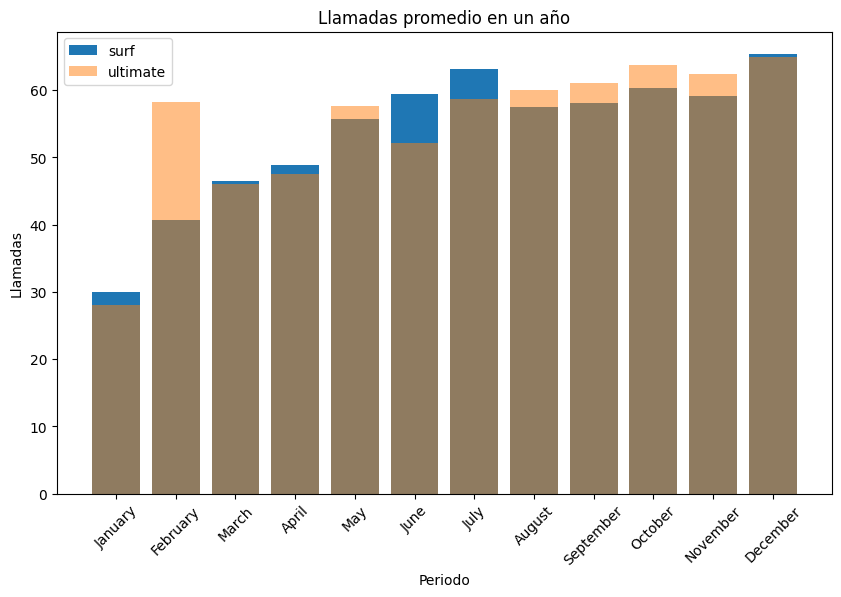

In [31]:
def Nombre_meses(df,columna):
    df[columna]=df[columna].dt.strftime("%B")
    return df

def Grafica_bar(df,columna):
    plt.figure(figsize=(10,6))
    for plan in df['plan_name'].unique():
        df_plan = df[df['plan_name'] == plan]
        if plan=="surf":
            plt.bar(df_plan['periodo'], df_plan[columna], label=plan,alpha=1)
        else:
            plt.bar(df_plan['periodo'], df_plan[columna], label=plan,alpha=0.5)
    return plt.gcf()

def Grafica_hist(df,columna):
    plt.figure(figsize=(10,6))
    plt.hist(df[columna], bins=10, alpha=0.5, label='Todos los planes')
    for plan in df['plan_name'].unique():
        df_plan = df[df['plan_name'] == plan]
        if plan=="surf":
            plt.hist(df_plan[columna], label=plan,alpha=0.6,bins=10)
        else:
            plt.hist(df_plan[columna], label=plan,alpha=0.8,bins=10)
    return plt.gcf()

def Var_Mean(df,columna):
    surf=df[df["plan_name"]=="surf"]
    ultimate=df[df["plan_name"]=="ultimate"]
    var=df[columna].var()
    mean=df[columna].mean()
    var_s=surf[columna].var()
    var_u=ultimate[columna].var()
    mean_s=surf[columna].mean()
    mean_u=ultimate[columna].mean()
    mediana=df[columna].median()
    
    return print(f"La varianza mensual es de {var} y la media es de {mean}\n La varianza mensual solo con plan ultimate es de {var_u} y la media es de {mean_u}\n La varianza mensual solo con plan surf es de {var_s} y la media es de {mean_s}\n La mediana es de {mediana}")

def caja(df,columna):
    sns.boxplot(df[columna])
    return plt.gcf()

#Aqui empieza 1.13.1
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
agr_1=df_allT.groupby(["periodo","plan_name"])["Month_call"].mean().reset_index()
agr_1=Nombre_meses(agr_1,"periodo")

Grafica_bar(agr_1,"Month_call")
plt.xlabel('Periodo')
plt.ylabel('Llamadas')
plt.title('Llamadas promedio en un año')
plt.xticks(rotation=45)
plt.legend()
plt.show()    


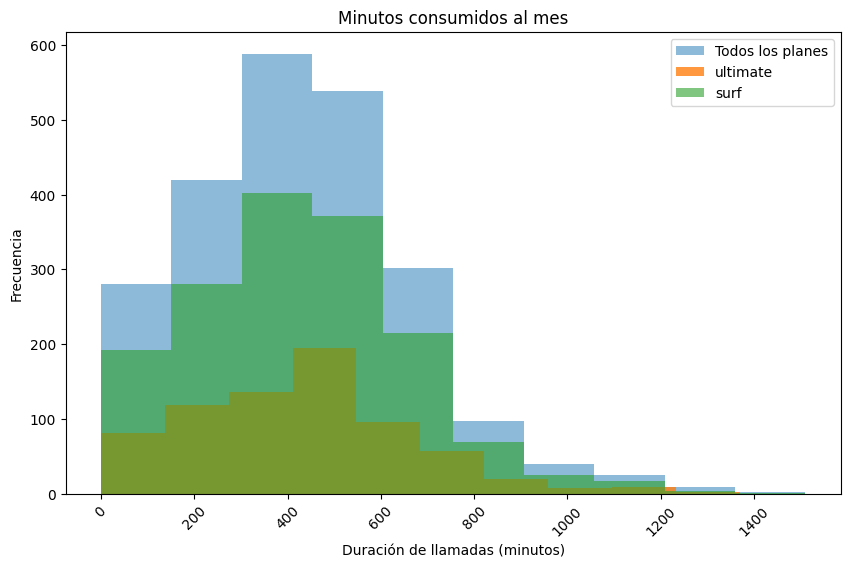

In [32]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
Grafica_hist(df_allT,"Month_duration")

plt.xlabel('Duración de llamadas (minutos)')
plt.ylabel('Frecuencia')
plt.title('Minutos consumidos al mes')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#Como no se especifíca y considero que comparar las gráficas es mejor cuando estan una encima de la otra deje el código activo 
#que consideré mejor, aún así en caso de que se necesiten por separado dejo este.

#agr_hist=df_allT.groupby(["periodo","plan_name"])["Month_duration"].mean().reset_index()

#agr_hist["periodo"]=agr_hist["periodo"].dt.strftime("%B")

#agr_hist_surf=agr_hist[agr_hist["plan_name"]=="surf"]
#agr_hist_ultimate=agr_hist[agr_hist["plan_name"]=="ultimate"]

#plt.figure(figsize=[12,6])
#plt.subplot(1,2,1)
#plt.title('Surf')
#plt.xlabel('Minutos mensuales')
#plt.ylabel('Frecuencia')

#plt.hist(agr_hist_surf['Month_duration'],alpha=1,bins=10)

#plt.subplot(1,2,2)
#plt.hist(agr_hist_ultimate['Month_duration'],alpha=1,bins=10)
#plt.title('Ultimate')
#plt.xlabel('Minutos mensuales')
#plt.ylabel('Frecuencia')

#plt.suptitle("Frecuencia de llamadas en los planes")
#plt.tight_layout()
#plt.show()


Obteniendo varianza y media

In [33]:
# Calcula la media y la varianza de la duración mensual de llamadas.
Var_Mean(df_allT,"Month_duration")

La varianza mensual es de 56401.63979518273 y la media es de 427.419452887538
 La varianza mensual solo con plan ultimate es de 58543.878651719744 y la media es de 428.0718232044199
 La varianza mensual solo con plan surf es de 55455.57740014497 y la media es de 427.12032932235593
 La mediana es de 424.0


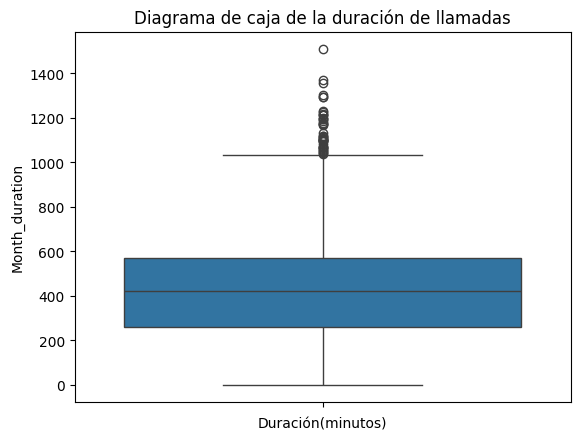

In [34]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
caja(df_allT,"Month_duration")
plt.title('Diagrama de caja de la duración de llamadas')
plt.xlabel('Duración(minutos)')
plt.show()

En primera instancia cuando nos referimos a las llamadas realizadas cada mes dependiendo del plan casi no se ven diferencias tan grandes, excepto en el mes de Febrero donde podemos observar que los que tienen el plan ultimate son más propensos a realizar llamadas probablemente debido al a las festividades que se tiene en el mes. 
Si tomamos en cuenta los minutos que se consumen al mes dependiendo del plan podemos observar que es más frecuente que las personas que tienen plan ultimate realicen  llamadas que duren de 410 a 550 minutos aproximadamente; mientras que para las personas con plan surf es de duración de 375 a 470 minutos aproximadamente, indicativo de que difiere en cierta medida el comportamiento de las llamadas en función del plan. 
Al obsevar el histograma podemos ver que si bien las figuras tienen areas que comparten el plan surf tiene un área mayor por lo que se ralizan un mayor número de llamadas con este plan además de que suelen durar más o hay más casos dond lo hacen. Al obtener la media en ambos casos observamos que son bastante similares dado que se tiene distribuciones proporcionales al tamaño.

### Mensajes

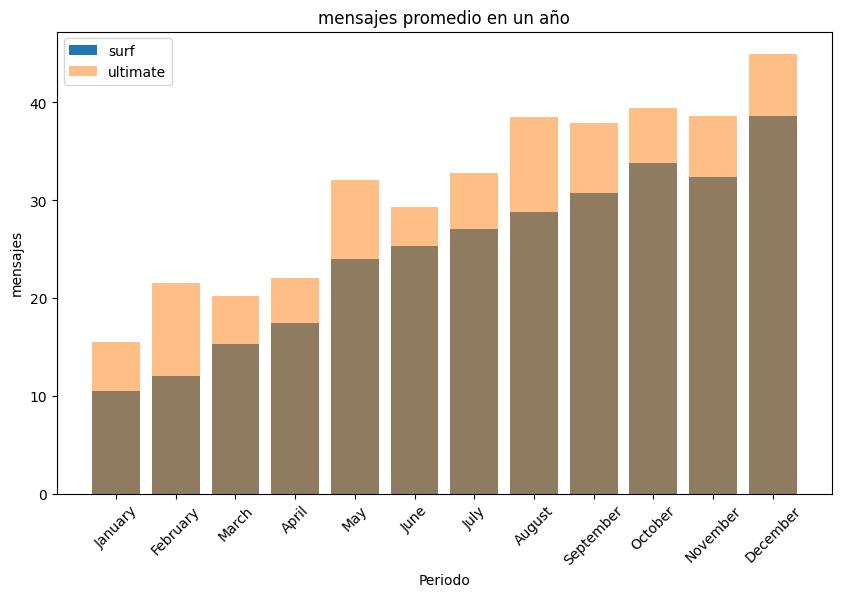

In [35]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
agr_2=df_allT.groupby(["periodo","plan_name"])["Month_message"].mean().reset_index()
agr_2=Nombre_meses(agr_2,"periodo")


Grafica_bar(agr_2,"Month_message")
plt.xlabel('Periodo')
plt.ylabel('mensajes')
plt.title('mensajes promedio en un año')
plt.xticks(rotation=45)
plt.legend()
plt.show()    

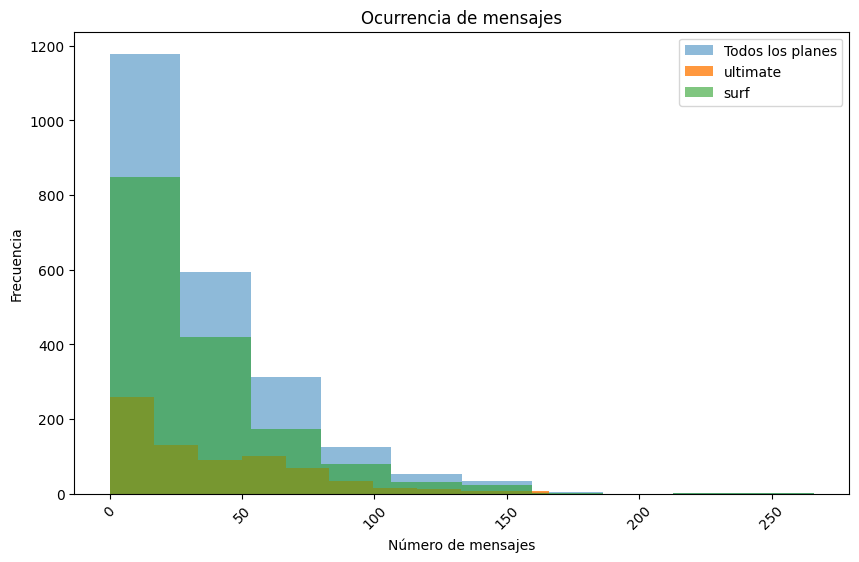

La varianza mensual es de 1160.4860234054247 y la media es de 33.02257924446374
 La varianza mensual solo con plan ultimate es de 1209.8276117007863 y la media es de 37.3439226519337
 La varianza mensual solo con plan surf es de 1126.1180762077681 y la media es de 31.041165294490185
 La mediana es de 25.0


In [36]:
Grafica_hist(df_allT,"Month_message")
plt.xlabel('Número de mensajes')
plt.ylabel('Frecuencia')
plt.title('Ocurrencia de mensajes')
plt.xticks(rotation=45)
plt.legend()
plt.show()    

Var_Mean(df_allT,"Month_message")

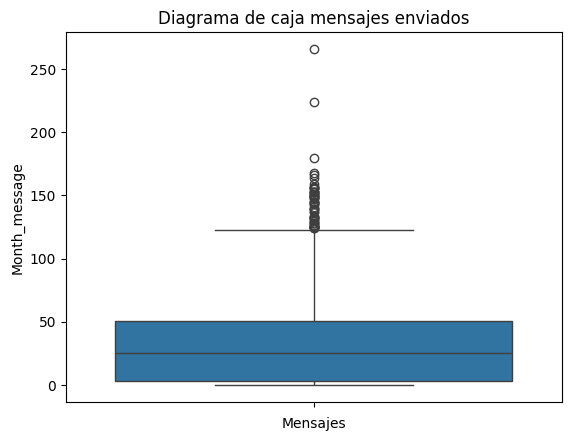

In [37]:
caja(df_allT,"Month_message")
plt.title('Diagrama de caja mensajes enviados')
plt.xlabel('Mensajes')
plt.show()

Hablando de los mensajes podemos observar que a lo largo del año los usuarios que tienen el plan ultimate suelen enviar más mensajes en promedio, esto se debe a que dentro de su plan el número de mensajes disponibles es mayor que al del plan surf dándoles una mayor libertad en cuanto a la cantidad que requieran gastar, si bien la media entre un plan y el otro no es tan diferente destaca las diferencias en las graficas obtenidas, en el histograma podemos ver una dominación mayor por parte del plan surf en cuanto área, esto se debe a que hay más usuarios del plan surf que plan ultimate.

Este análisis nos da un indicio que los mensajes el plan ultimate son más utilizados que en el plan surf, cabe notar que el sesgo del diagrama de caja es derecho y la mediana es más cercana al valor de la media del plan surf (25 y 31.041165294490185 respectivamente) y que los valores después del 120 mensajes enviados aproximadamenre pertenecen a valores atípicos dentro de nuestro análisis. 

### Internet

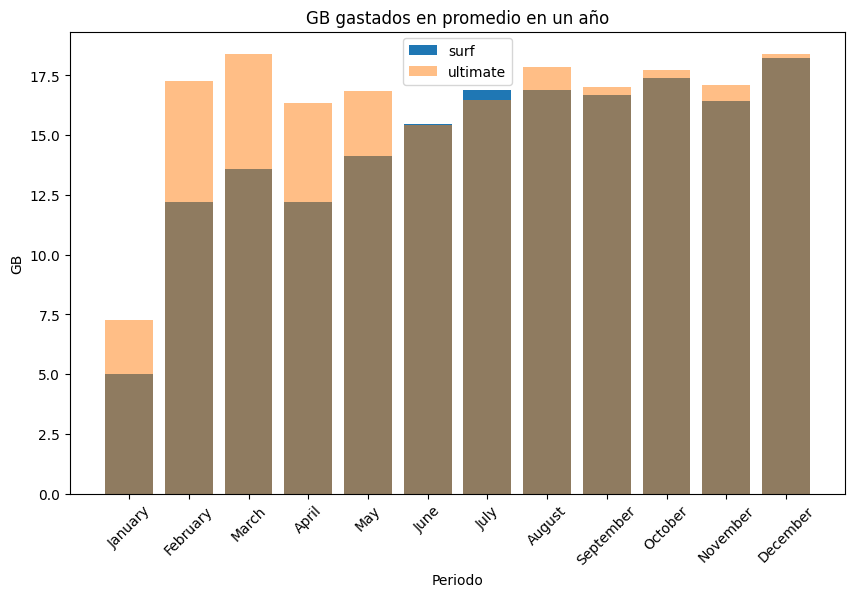

In [38]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
agr_3=df_allT.groupby(["periodo","plan_name"])["Month_GB"].mean().reset_index()

agr_3=Nombre_meses(agr_3,"periodo")

Grafica_bar(agr_3,"Month_GB")
plt.xlabel('Periodo')
plt.ylabel('GB')
plt.title('GB gastados en promedio en un año')
plt.xticks(rotation=45)
plt.legend()
plt.show()   


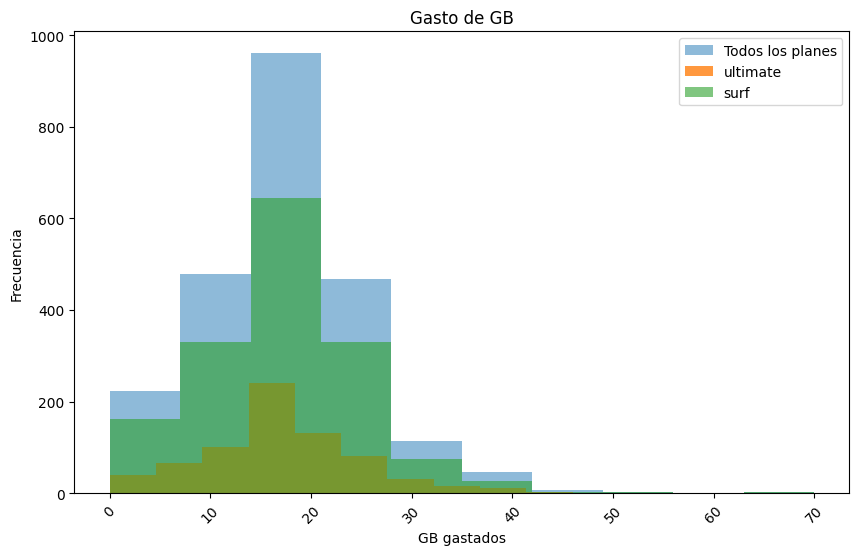

La varianza mensual es de 61.74730765182573 y la media es de 16.797221016066
 La varianza mensual solo con plan ultimate es de 60.153066565797815 y la media es de 17.21132596685083
 La varianza mensual solo con plan surf es de 62.40212597053693 y la media es de 16.60734642178594
 La mediana es de 17.0


In [39]:
Grafica_hist(df_allT,"Month_GB")
plt.xlabel('GB gastados')
plt.ylabel('Frecuencia')
plt.title('Gasto de GB')
plt.xticks(rotation=45)
plt.legend()
plt.show() 
Var_Mean(df_allT,"Month_GB")

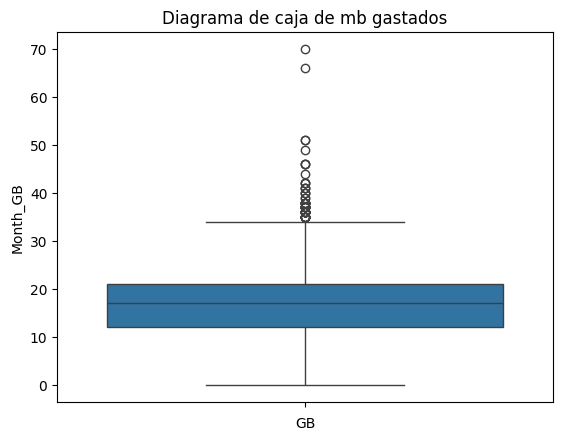

In [40]:
caja(df_allT,"Month_GB")
plt.title('Diagrama de caja de mb gastados')
plt.xlabel('GB')
plt.show()

Si hablamos del uso de internet a través de los GB gastados a lo largo de un año nos damos cuenta que a mayor cantidad de GB disponibles en el plan más gasto de GB se tiene, esto tiene sentido ya que un usuario que tiene la necesidad de estar conectado a internet por ciertos motivos lo usará más a menudo razón por la cual elegirá un plan que le otorgue un paquete de GB sufucientes para su día a día, analizando el histograma vemos que tomando en cuenta la proporción el comportamiento de gastos entre los usuarios ultimate y surf es muy cercano, el diagrama de caja está sesgado a la izquierda y que el gasto por encima de los 33 GB aproximadamente es raro pero si hay casos, por lo que podemos decir que si bien no hay una diferencia alta en este caso las personas del plan ultimate sulen explotar más el gasto de GB seguramente porque tienen una mayor cantidad disponible antes de que se les penalice por excederse. 

## Ingreso

Obteniendo el comportamiento de los ingresos por ususario cada mes.

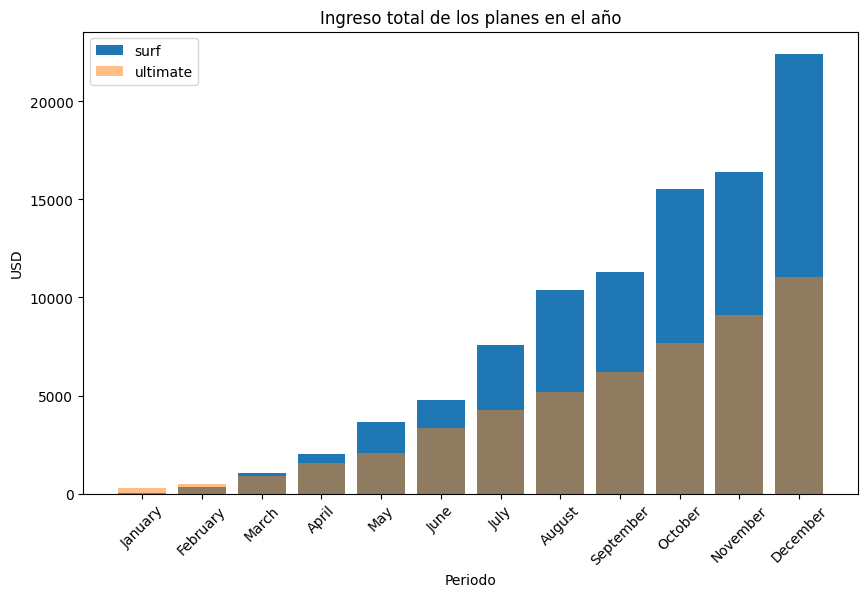

In [41]:
agr_4=df_allT.groupby(["periodo","plan_name"])["total"].sum().reset_index()
agr_4=Nombre_meses(agr_4,"periodo")
Grafica_bar(agr_4,"total")
plt.xlabel('Periodo')
plt.ylabel('USD')
plt.title('Ingreso total de los planes en el año')
plt.xticks(rotation=45)
plt.legend()
plt.show()    

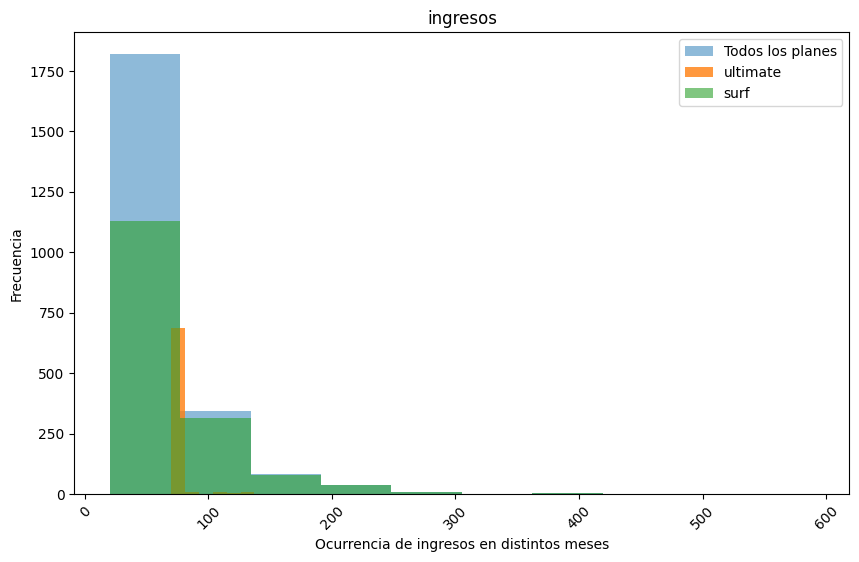

La varianza mensual es de 2169.613234138677 y la media es de 64.2454103343465
 La varianza mensual solo con plan ultimate es de 129.15955617707067 y la media es de 72.3011049723757
 La varianza mensual solo con plan surf es de 3062.4468636121587 y la media es de 60.551728942368584
 La mediana es de 70.0


In [42]:
Grafica_hist(df_allT,"total")
plt.xlabel('Ocurrencia de ingresos en distintos meses')
plt.ylabel('Frecuencia')
plt.title('ingresos')
plt.xticks(rotation=45)
plt.legend()
plt.show()  
Var_Mean(df_allT,"total")

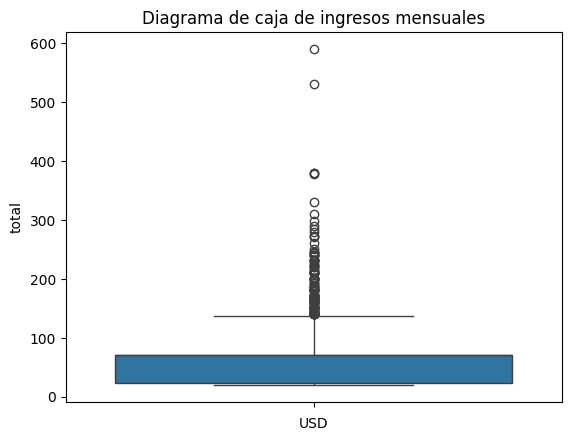

In [43]:
caja(df_allT,"total")
plt.title('Diagrama de caja de ingresos mensuales')
plt.xlabel('USD')
plt.show()

En este caso podemos ver en las gráficas que predomina el plan surf, esto se debe a que si bien mensualmente tiene un precio mensual menor al ultime el usuriario al excederse tiene que pagar una cantidad de dinero significativa frente a la que tiene que pagar un usuario del plan ultime si este se excede, dado que la cantidad a pagar es mayor hace que los ingresos de obtenidos del plan surf sean mayores al otro, además hay que tomar en cuenta que el paquete de datos que obtiene un usuario (mb, mensajes y llamadas) surf son bastante menores a los del plan ultimate y por lo consiguiente los usuarios del plan surf serán más suceptibles a excederse.
Si tomamos en cuenta lo anterior podemos deducir que para usuarios de plan ultimate el pago mensual que realizan no es muy diferente a la cuota establecida por el plan, sin embargo, para el plan surf hay tantas circunstancias en las que pueden excederse por lo que ingreso obtenido en el plan surf es mayor que el que se obtiene en el plan ultimate, se puede obervar este comportamiento en el histograma donde plan ultimate es símetrico y el plan ultimate muestra un sesgo a la derecha debido a la cantidad de excesos exsitentes en el periodo presentado.

## Prueba las hipótesis estadísticas

Hipótesis nula: El ingreso promedio mensual de los usuarios no es diferente según el plan.

In [44]:
# Prueba las hipótesis
df_allT_S=df_allT[df_allT["plan_name"]=="surf"]
df_allT_U=df_allT[df_allT["plan_name"]=="ultimate"]

surf_mean=df_allT_S["total"].mean()
ultimate_mean=df_allT_U["total"].mean()
surf_var=np.var(df_allT_S["total"])
ultimate_var=np.var(df_allT_U["total"])
alpha= 0.05

print(f"El promedio de ingresos del plan ultimate es {ultimate_mean} y el del plan surf es {surf_mean}")
print(f"Varianza del plan ultimate es: {ultimate_var} y la varianza del plan surf es: {surf_var}")

results = st.ttest_ind(df_allT_S["total"],df_allT_U["total"] ,equal_var=False)
print('valor p:', results.pvalue)

if (results.pvalue<alpha):
    print("Rechazamos la hipótesis nula")
    print("Hay diferencias significativas entre los ingresos entre el plan surf con el plan ultimate")
else:
    print("No podemos rechazar la hipótesis nula")
    print("No hay diferencias significativas entre los ingresos entre el plan surf con el plan ultimate")


El promedio de ingresos del plan ultimate es 72.3011049723757 y el del plan surf es 60.551728942368584
Varianza del plan ultimate es: 128.98115900003052 y la varianza del plan surf es: 3060.5073785813724
valor p: 1.218411585212325e-15
Rechazamos la hipótesis nula
Hay diferencias significativas entre los ingresos entre el plan surf con el plan ultimate


Hipótesis nula: El ingreso promedio de los usuarios del área NY-NJ no es diferente al de los usuarios de otras regiones. 

In [45]:
# Prueba las hipótesis
si_NNYJ=df_allT[df_allT["city"].str.contains("NY-NJ")]
#print(si_NNYJ["city"].unique())
no_NNYJ=df_allT[~df_allT["city"].str.contains("NY-NJ")]
#print(no_NNYJ)

si_mean=si_NNYJ["total"].mean()
no_mean=no_NNYJ["total"].mean()
si_var=np.var(si_NNYJ["total"])
no_var=np.var(no_NNYJ["total"])
alpha= 0.05

print(f"El promedio de ingresos en las regiones New York-Newark-Jersey City es {si_mean} y el del resto de regiones es {no_mean}")
print(f"Varianza de la región New York-Newark-Jersey Cityes es: {si_var} y la varianza del resto de regiones es: {no_var}")

results2 = st.ttest_ind(si_NNYJ["total"],no_NNYJ["total"] ,equal_var=True)
print('valor p:', results2.pvalue)

if (results2.pvalue<alpha):
    print("Rechazamos la hipótesis nula")
    print("Hay diferencias significativas entre el ingreso del área NY-NJ con el resto de regiones")
else:
    print("No podemos rechazar la hipótesis nula")
    print("No hay diferencias significativas entre el ingreso del área NY-NJ con el resto de regiones")



El promedio de ingresos en las regiones New York-Newark-Jersey City es 59.94801587301587 y el del resto de regiones es 65.08926233766235
Varianza de la región New York-Newark-Jersey Cityes es: 1885.7843645817586 y la varianza del resto de regiones es: 2219.881380131179
valor p: 0.04974528277407551
Rechazamos la hipótesis nula
Hay diferencias significativas entre el ingreso del área NY-NJ con el resto de regiones


## Conclusión general
Después de realizar los análisis correspondientes a este proyecto podermos decir que el plan surf es más rentable que el plan ultimate pues del primero se perciben mayores ingresos, esto se debe a que los usuarios suelen excederse en las llamadas, mensajes y GBs permitidos dentro plan, por lo que suelen pagar más que la tarifa, mientras que los usuarios del plan ultimate no suelen presentar excesos tan a menudo y de hacerlo no son significativamente grandes a comparación del precio de la tarifa establecida. 

El comportamiento de los ususarios del plan ultimate suele ser mayor respecto al uso de los recuerso que el de los usuarios surf pero al no excederse el ingreso no es mayor, además que al observar cada uno de los análisis realizados a las áreas de interés podemos ver una mayor cantidad de usuarios que tiene el plan surf, por lo que histogramas como diagramas de caja que nos hablan del comportamiento en general serán más suceptibles a los valores atípicos provenientes de los usuarios del plan surf.

Tomando en cuenta lo del párrafo anterior podemos comprender porque las regiones de New York-Newark-Jersey City tienen un ingreso similar a la suma del resto de las regiones (por el alto vólumen de pesonas que viven o realizan actividades en esas localizaciones), sin embargo, no es lo suficientemente grande como para ser similar por lo que es significativamente mayor el ingreso obtenido en el resto de regiones que en las regiones de New York-Newark-Jersey City.